## _*H2 ground state energy computation using Iterative QPE*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using IQPE (Iterative Quantum Phase Estimation) algorithm. It is compared to the same energies as computed by the ExactEigensolver

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the qiskit_chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

In [1]:
import unittest

import numpy as np
import qiskit
from qiskit.transpiler import PassManager
from qiskit.aqua.utils import decimal_to_binary
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.single_sample import IQPE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator, QiskitChemistryError
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
import pylab
from qiskit import Aer
from qiskit.chemistry import QiskitChemistry
import time
import multiprocessing as mp

def compute_energy(i, distance, algorithm):
    try:
        driver = PySCFDriver(
            atom='H .0 .0 .0; H .0 .0 {}'.format(distance),
            unit=UnitsType.ANGSTROM,
            charge=0,
            spin=0,
            basis='sto3g'
        )
    except QiskitChemistryError:
        raise AquaError('PYSCF driver does not appear to be installed')
    molecule = driver.run()
    qubit_mapping = 'parity'
    fer_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubit_op = fer_op.mapping(map_type=qubit_mapping, threshold=1e-10).two_qubit_reduced_operator(2)

    if algorithm.lower() == 'exacteigensolver':
        exact_eigensolver = ExactEigensolver(qubit_op, k=1)
        result = exact_eigensolver.run()
        reference_energy = result['energy']
    elif algorithm.lower() == 'iqpe':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 500
        num_iterations = 12
        state_in = HartreeFock(qubit_op.num_qubits, num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        iqpe = IQPE(qubit_op, state_in, num_time_slices, num_iterations,
                    expansion_mode='suzuki', expansion_order=2,
                    shallow_circuit_concat=True)
        backend = qiskit.BasicAer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=100, pass_manager=PassManager())

        result = iqpe.run(quantum_instance)
    else:
        raise AquaError('Unrecognized algorithm.')
    return i, distance, result['energy'] + molecule.nuclear_repulsion_energy, molecule.hf_energy

In [2]:
import concurrent.futures
import multiprocessing as mp

# print(compute_energy(1, 0.735, 'iqpe'))
algorithms = ['iqpe', 'exacteigensolver']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
max_workers = max(4, mp.cpu_count())
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for j in range(len(algorithms)):
        algorithm = algorithms[j]
        for i in range(steps+1):
            d = start + i*by/steps
            future = executor.submit(
                compute_energy, 
                i, 
                d, 
                algorithm
            )
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            i, d, energy, hf_energy = future.result()
            energies[j][i] = energy
            hf_energies[i] = hf_energy
            distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05422048 -1.07537168 -1.09248138 -1.10399559 -1.11475705 -1.12615725
  -1.12908795 -1.13229119 -1.13797555 -1.13620458 -1.13727841 -1.13633094
  -1.13450418 -1.13191917 -1.12962398 -1.12580925 -1.1215069  -1.11678337
  -1.11169625 -1.10808228 -1.10150938]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
Hartree-Fock energies: [-1.04299627 -1.06306214 -1.07905074 -1.0915705  -1.10112824 -1.10814999
 -1.11299655 -1.11597526 -1.11734903 -1.11734327 -1.11615145 -1.11393966
 -1.1108504  -1.10700581 -1.10251055 -1.09745432 -1.09191404 -1.08595587
 -1.07963693 -1.07300676 -1.06610865]
--- 286.98989701271057 seconds -

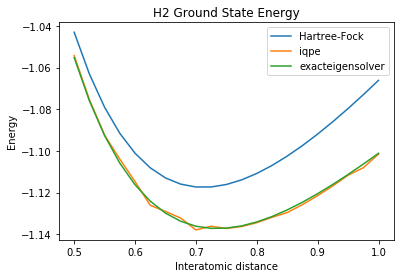

In [3]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

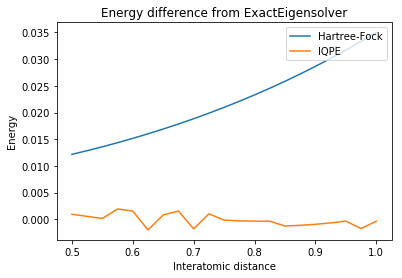

In [4]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper right')
pylab.show()